## pyNX simulation example using 2D Images
- Objective: To reverse engineer the pynx.ptycho.simulation code to understand all of the simulation steps 
- To create a working 2D example for ANY image in the universe
- Once simulation is understood, deep-dive into phase-retrieval and reconstruction problem. (For now, just table the 3d problem. ONLY 2D problems are considered)

Here we are considering 2D ptychography using diffraction patterns simulated using images. 
---- We can also use CXI files for 3D CDI. ----

## 0. Import Libraries

In [1]:
import numpy as np
from numpy import pi
from scipy import misc
import sys
import timeit

from IPython import display
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as wg
import cv2
from pylab import *
%matplotlib inline

from pynx.ptycho import simulation, shape
from pynx.ptycho import *
from pynx.utils.pattern import siemens_star

/opt/miniconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


## 1. Read any image
- Here we are reading the same image from disk and resizing to 512x512 resolution. 
- We will use these images as amplitude and phase of the object function.

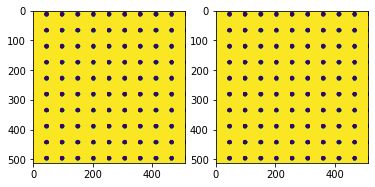

In [2]:
# 1.1 Amplitude image
# im = misc.face()
im = cv2.imread("6402429_preview.png",0) # Reading color image as grayscale
resized_im = cv2.resize(im[80:500, 80:500], (512, 512)) # We will always fix the image size with dimensions divisible by 8
# resized_grayscaled_im = cv2.cvtColor(resized_im, cv2.COLOR_BGR2GRAY) # Convert RGB Channels to Grayscale for easier processing


# 1.2 Phase image
ph = misc.ascent()
ph = cv2.imread("6402429_preview.png",0)
resized_ph = cv2.resize(ph[80:500, 80:500], (512, 512)) # We will always fix the image size with dimensions divisible by 8
# resized_grayscaled_ph = cv2.cvtColor(resized_ph, cv2.COLOR_BGR2GRAY) # Convert RGB Channels to Grayscale for easier processing


# Plot the resized and gray-scaled image
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(resized_im)
ax2.imshow(resized_ph)
plt.show()

## 2. Simulate diffraction patterns for the image

In [3]:
##################
# Experimental settings
detector_distance = 1
wavelength = 1.5e-10
pixel_size_detector = 1e-6

# Simulation of the ptychographic data:
n = 256 # Probe pixels 256x256

# Stretch the phase to interval (-phase_stretch/2, +phase_stretch/2)
phase0 = resized_ph - resized_ph.min()
ps = 2 * np.pi
phase_stretch = ps * phase0 / phase0.max() - ps / 2.
obj = resized_im * np.exp(1j * phase_stretch)

# obj = resized_im + 1j * resized_ph # Convert the real space image to complex (Required to be fed into pyNX simulation)


### OBJECT INFORMATION
obj_info = {'type': 'phase_ampl', 'phase_stretch': pi / 2, 'alpha_win': .2}



### PROBE INFORMATION
probe_info = {'type': 'near_field', 'aperture': (80e-6, 80e-6), 'defocus': 0.5, 'shape': (n, n)}



### SCANNING METHODS (possible methods 'raster' and 'spiral')
# Here we scan 80 positions by moving the probe (moving the probe by 20 pixels after each scan and in a spiral fashion)
scan_info = {'type': 'spiral', 'scan_step_pix': 10, 'n_scans': 80}



### OUTPUT Diffraction data will depend upon the experimental settings like detector_distance(in m), wavelength of x-rays(in m), detector pixel-size(in m)
data_info = {'num_phot_max': 1e9, 'bg': 0, 'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector, 'noise': 'poisson', 'near_field': True}



### Initialisation of the simulation
# s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
s = simulation.Simulation(obj=obj, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
# Data simulation: probe.show(), obj.show(), scan.show() and s.show_illumination_sum() will visualise the integrated total coverage of the beam
s.make_data()

posy, posx = s.scan.values
ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity

Simulating probe: near_field
Simulating scan: spiral
Simulating ptychographic data [80 frames].
80 70 60 50 40 30 20 10 

Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': 1000000000.0, 'bg': 0, 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelength': 1.5e-10, 'detector_distance': 1, 'detector_pixel_size': 1e-06, 'near_field': True}
Scan info: {'type': 'spiral', 'scan_step_pix': 10, 'n_scans': 80, 'integer_values': True}
Object info: {'type': 'Custom', 'border_pix': 2}
Probe info: {'type': 'near_field', 'shape': (256, 256), 'sigma_pix': (50, 50), 'rotation': 0, 'aperture': (8e-05, 8e-05), 'defocus': 0.5}


amplitude_phase


/opt/miniconda3/lib/python3.7/site-packages/pynx/utils/plot_utils.py:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


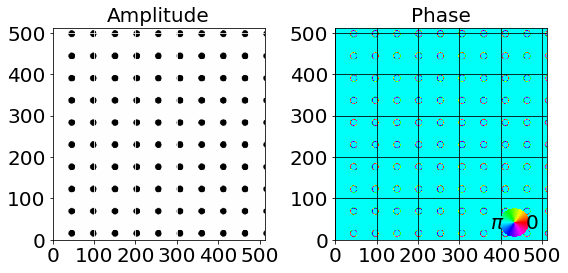

amplitude_phase


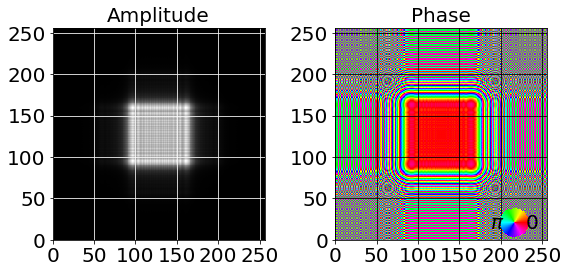

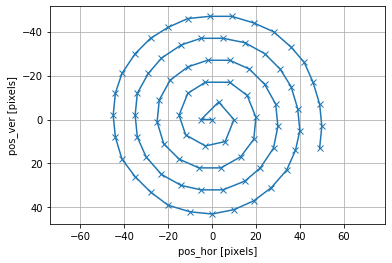

In [4]:
s.obj.show()
s.probe.show()
s.scan.show()

In [5]:
##################
# Evaluation:
# Size of the reconstructed object (obj)
nyo, nxo = shape.calc_obj_shape(posy, posx, ampl.shape[1:])

# Initial object
# obj_init_info = {'type':'flat','shape':(nx,ny)}
obj_init_info = {'type': 'random', 'range': (0, 1, 0, 0.5), 'shape': (nyo, nxo)}
# Initial probe
probe_init_info = {'type': 'near_field', 'aperture': (85e-6, 85e-6), 'defocus': 0.3, 'shape': (n, n)}
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)

init.make_obj()
init.make_probe()

data = PtychoData(iobs=ampl ** 2, positions=(posy * pixel_size_detector, posx * pixel_size_detector),
                  detector_distance=detector_distance, mask=None,
                  pixel_size_detector=pixel_size_detector, wavelength=wavelength, near_field=True)

p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=None)

# Initial scaling is important to avoid overflows during ML
p = ScaleObjProbe() * p

Simulating object: random
Simulating probe: near_field


## 3. Visualizing Diffraction patterns alongside probe position

In [6]:
def myplot(c):
    x = np.linspace(start=-10, stop=10, num=50)
    y = c * x**2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), dpi = 80, constrained_layout=True) # Constrained layout makes sure that the title texts don't overlap
    fig.suptitle('Scan position of probe(left) and Diffraction pattern(right)', fontsize=15)
    ax1.set_title("Spiral scan position"
                 , fontdict={'fontfamily': 'monospace'
                             , 'fontstyle': 'normal'
                             , 'fontsize': 20
                             , 'fontweight': 'medium'})
    # plt.axis('scaled')
    ax1.set_ylim([-150,150])
    ax1.set_xlim([-150,150])
    ax1.plot(s.scan.values[1][:c], s.scan.values[0][:c], '-x')
    ax1.set_xlabel('pos_hor [pixels]', fontdict={'fontfamily': 'monospace'
                             , 'fontstyle': 'normal'
                             , 'fontsize': 16
                             , 'fontweight': 'normal'})
    ax1.set_ylabel('pos_ver [pixels]', fontdict={'fontfamily': 'monospace'
                             , 'fontstyle': 'normal'
                             , 'fontsize': 16
                             , 'fontweight': 'normal'})
    ax1.grid(b=True)
    
    amplitudes=s.amplitude.values[c]
    ints=np.abs(amplitudes)**2
    im2 = ax2.imshow(np.log(ints + 0.0001),cmap='jet',vmin=0)
    ax2.set_title('Diffraction Pattern  I(q). Position: {}'.format(c+1),fontsize=18)
    
scan_number = wg.IntSlider(description = 'Scan Number:', min=0, max=s.scan.info['n_scans'])
wg.interact(myplot, c=scan_number);

interactive(children=(IntSlider(value=0, description='Scan Number:', max=80), Output()), _dom_classes=('widget…

## IMP: Downsampling

In [7]:
def rebin(a, shape):
    # Function to downsample any 2d numpy array
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

a = np.arange(24).reshape((4,6))
print('a = ', a, '\nrebin-a = ', rebin(a, (2, 3)))
#ampl[0]



def bin_ndarray(ndarray, new_shape, operation='mean'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean', 'min', 'max']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

print('\nrebin-a = ', bin_ndarray(a, (2, 3), 'mean'))

a =  [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]] 
rebin-a =  [[ 3.5  5.5  7.5]
 [15.5 17.5 19.5]]

rebin-a =  [[ 3.5  5.5  7.5]
 [15.5 17.5 19.5]]


- Downsampling the diffraction patterns using average pooling (2x2) window is averaged out to get the value of 1 pixel in downsampled array. 
- Reduces the total number of pixels by a factor of 4 
- Creating a downsampled image of size 128x128 (which was originally 256x256)

In [8]:
xampl = np.zeros(shape=(ampl.shape[0], 128, 128))
for i in range(ampl.shape[0]):
    xampl[i] = rebin(a=ampl[i], shape=(128, 128))

In [9]:
xampl[1]

array([[82.28897973, 29.48714247, 82.30746163, ..., 63.43349623,
        50.25886282, 51.17536752],
       [28.53559029, 12.81150824, 30.70117131, ..., 22.9842143 ,
        18.4241948 , 18.93947519],
       [75.57822338, 27.85882807, 76.95174725, ..., 62.08745751,
        51.14191859, 46.50651974],
       ...,
       [74.3468459 , 24.59430777, 60.32504836, ..., 45.03648456,
        34.80203013, 48.20132682],
       [58.78146202, 21.18015893, 54.03054712, ..., 35.95779854,
        27.87978538, 42.43831735],
       [50.76003933, 18.48672734, 52.13934344, ..., 35.92396113,
        27.94755154, 32.49430524]])

- Random initialization of mask for fourier ptychography

In [10]:
##################
# Evaluation:
# Size of the reconstructed object (obj)
nyo, nxo = shape.calc_obj_shape(posy/2, posx/2, (256, 256))

# Initial object
# obj_init_info = {'type':'flat','shape':(nx,ny)}
obj_init_info = {'type': 'random', 'range': (0, 1, 0, 0.5), 'shape': (nyo, nxo)}
# Initial probe
probe_init_info = {'type': 'near_field', 'aperture': (85e-6, 85e-6), 'defocus': 0.3, 'shape': (256, 256)}
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)

init.make_obj()
init.make_probe()

data = PtychoData(iobs=xampl ** 2, positions=(posy/2 * pixel_size_detector, posx/2 * pixel_size_detector),
                  detector_distance=detector_distance, mask=None,
                  pixel_size_detector=pixel_size_detector, wavelength=wavelength, near_field=True)

p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=None)

# Initial scaling is important to avoid overflows during ML
p = ScaleObjProbe() * p

Simulating object: random
Simulating probe: near_field


## 5. Phase retrieval and reconstruction

Difference Map optimization Initialized!
DM/o/p     #  0 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=1.563s
DM/o/p     #  5 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.019s
DM/o/p     # 10 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.018s
DM/o/p     # 15 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.017s
DM/o/p     # 20 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.016s
DM/o/p     # 25 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.016s
DM/o/p     # 30 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.020s
DM/o/p     # 35 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.020s
DM/o/p     # 40 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.016s
DM/o/p     # 45 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.017s
DM/o/p     # 50 LLK=      nan(p)      inf(g)      inf(e), n

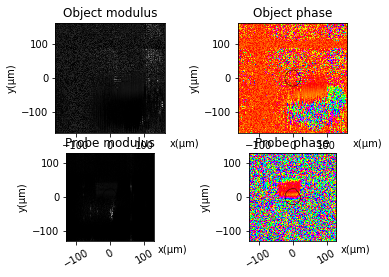

Difference Map optimization completed!
Alternating Projections optimization Initialized!
AP/o/p     #1000 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.021s
AP/o/p     #1005 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.019s
AP/o/p     #1010 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.019s
AP/o/p     #1015 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.020s
AP/o/p     #1020 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.019s
AP/o/p     #1025 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.018s
AP/o/p     #1030 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.020s
AP/o/p     #1035 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.019s
AP/o/p     #1040 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.017s
AP/o/p     #1045 LLK=      nan(p)      inf(g)      inf(e), nb photons=inf, dt/cycle=0.020s
A

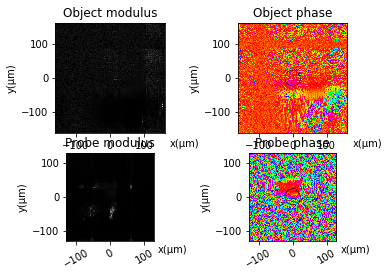

Alternating Projections optimization completed!


In [11]:
%matplotlib inline
print("Difference Map optimization Initialized!")
p = ShowObjProbe(fig_num=1) * DM(update_object=True, update_probe=True, calc_llk=5, ) ** 1000 * p
print("Difference Map optimization completed!\nAlternating Projections optimization Initialized!")
p = ShowObjProbe(fig_num=1) * AP(update_object=True, update_probe=True, calc_llk=5) ** 1000 * p
print("Alternating Projections optimization completed!")